In [1]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


# here, due to memory issues i am taking only 4000 reviews that i would work with



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative 0'
    return 'positive 1'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
filtered_data.sort_values('Time',inplace=True) 

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(525814, 10)


Id   ProductId          UserId         ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR  Nicholas A Mesiano   
417839  451856  B00004CXX9   AIUWLEQ1ADEG5    Elizabeth Medina   
417859  451878  B00004CXX9  A344SMIA5JECGM     Vincent P. Ross   
212472  230285  B00004RYGX  A344SMIA5JECGM     Vincent P. Ross   

        HelpfulnessNumerator  HelpfulnessDenominator       Score       Time  \
138706                     0                       0  positive 1  939340800   
138683                     2                       2  positive 1  940809600   
417839                     0                       0  positive 1  944092800   
417859                     1                       2  positive 1  944438400   
212472                     1                       2  positive 1  944438400   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   
417859                            A modern day fairy tale   
212472                            A modern day fairy tale   

                                                     Text  
138706  this witty little book makes my son laugh at l...  
138683  I can remember seeing the show when it aired o...  
417839  Beetlejuice is a well written movie ..... ever...  
417859  A twist of rumplestiskin captured on film, sta...  
212472  A twist of rumplestiskin captured on film, sta...

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape



(364173, 10)

In [4]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [5]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY Time
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
1  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       2      4  1212883200   
1                     3                       1      5  1224892800   

                                        Summary  \
0  Pure cocoa taste with crunchy almonds inside   
1             Bought This for My Son at College   

                                                Text  
0  It was almost a 'love at first bite' - the per...  
1  My son loves spaghetti so I didn't hesitate or...

In [6]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]


#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive 1    307061
negative 0     57110
Name: Score, dtype: int64

In [7]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Summary:  A young boy describes the usefulness of chicken soup with rice for each month of the year.<br /><br />Evaluation:  With Sendak's creative repetitious and rhythmic words, children will enjoy and learn to read the story of a boy who loves chicken soup with rice!  Through Sendak's catchy story, children will also learn the months of the year, as well as what seasons go with what month! They learn to identify ice-skating and snowmen in the winter; strong wind in March; birds and flowers in the spring; swimming and hot temperatures in the summer; and finally different holidays throughout the year. Such as Halloween in October, and Christmas in December.<br /><br />Sendak's simple three colored crayon-like drawings are a perfect addition to his educational and entertaining story.<br /><br />A great activity that you can do with this book is to have children draw their own illustrations for each month of the year.  Afterwards you can bind the pages together so the children can cre

In [8]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'just', 'him', 'their', 'have', 'as', 'couldn', 'no', "won't", 'not', 'me', 'are', 'by', 'of', 'once', 'out', 'weren', 'wasn', 'wouldn', 'y', 'i', 'd', "weren't", 'himself', 'yourselves', 'during', "isn't", 'didn', 'myself', 're', 'she', 'isn', 'will', 'further', 'under', 'nor', 'until', "hasn't", 'down', 'won', 'while', "mightn't", 'after', "wouldn't", 'yourself', 'does', 'mustn', 'were', 'do', 'to', 'm', 'ain', 'up', 'at', 'but', 'some', 'don', 't', 'been', 'against', 'only', "mustn't", 'those', 'was', 'through', "should've", 'o', 'haven', 'am', 'ourselves', 'mightn', 'too', 'what', 'hadn', 'with', 'so', 'in', 'be', 'from', "couldn't", 'whom', "haven't", 'needn', 'it', 'which', 'this', 'they', 'off', 'did', 'you', 'where', 'into', 'there', 'its', 'can', "you'll", 'other', 'herself', "you're", 'very', 'here', 've', 'now', 'hasn', 'themselves', 'an', 'below', "it's", 'again', 'most', 'yours', 'above', 'his', "shouldn't", 'should', 'or', 'on', 'all', "she's", 'how', 'and', 'about', 'an

In [9]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [10]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [11]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [13]:
final.head() #below the processed review can be seen in the CleanedText Column 

Id   ProductId          UserId  \
138706  150524  0006641040   ACITT7DI6IDDL   
138705  150523  0006641040  A2P4F2UO0UMP8C   
138699  150517  0006641040   ABW4IC5G5G8B5   
138680  150498  0006641040  A3SJWISOCP31TR   
138689  150507  0006641040  A1S4A3IQ2MU7V4   

                                  ProfileName  HelpfulnessNumerator  \
138706                        shari zychinski                     0   
138705  Elizabeth A. Curry "Lovely Librarian"                     0   
138699                            kevin clark                     0   
138680                            R. J. Wells                     2   
138689                  sally sue "sally sue"                     1   

        HelpfulnessDenominator       Score        Time  \
138706                       0  positive 1   939340800   
138705                       0  positive 1  1096675200   
138699                       0  positive 1  1291075200   
138680                       2  positive 1  1176336000   
138689                       1  positive 1  1191456000   

                              Summary  \
138706      EVERY book is educational   
138705          MMMM chicken soup....   
138699              good for children   
138680                A Gem of a Book   
138689  chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138705  Summary:  A young boy describes the usefulness...   
138699  Classic children's book, can't go wrong. I rea...   
138680  This is a wonderful little book. I loved it 40...   
138689  This is a fun way for children to learn their ...   

                                              CleanedText  
138706  witti littl book make son laugh loud recit car...  
138705  young boy describ use chicken soup rice month ...  
138699  classic children book cant wrong read kid orde...  
138680  wonder littl book love year ago twin love enjo...  
138689  fun way children learn month year learn poem t...

In [12]:
final = final.sample(n = 100000, replace = True) # Sampling 100k rows 
final = pd.DataFrame(final)
final.head()

Id   ProductId          UserId  \
58291    63238  B006BXUVPY  A3QMIWXU2RGEMH   
32759    35655  B0012KH0CS  A3AVS3NN9SX02S   
356484  385597  B000329QNC   AU7AY2NOFQ7SO   
288940  312969  B008Y3VIGK   ALDG6DEZ01HOO   
523271  565693  B002GKEK7G  A2DC48FKBGFW4Z   

                                     ProfileName  HelpfulnessNumerator  \
58291                               Lee S. Mairs                     0   
32759                            Jane M. Martell                     0   
356484                       Frederik Green "FG"                     2   
288940                                    Amanda                     0   
523271  My name is Shake-zula. "Lilliana Gamez."                     0   

        HelpfulnessDenominator       Score        Time  \
58291                        1  positive 1  1336003200   
32759                        0  positive 1  1348272000   
356484                       2  positive 1  1259193600   
288940                       0  positive 1  1350691200   
523271                       0  negative 0  1346716800   

                                                 Summary  \
58291   A Candidate for the DEA's Banned Substances List   
32759                                Cats love this food   
356484                          Chiver's Ginger Preserve   
288940                                     Great quality   
523271                                       Half empty.   

                                                     Text  \
58291   these new Cheez-Its with the Mozzarella flavor...   
32759   My seven cats just love this food and I am alw...   
356484  This is simply the best ginger preserve in the...   
288940  The delivery of my mini star sprinkles was qui...   
523271  I haven't tried it yet.. but so far not please...   

                                              CleanedText  
58291   new mozzarella flavor incred addict went entir...  
32759   seven cat love food alway look new batch case ...  
356484  simpli best ginger preserv world actual think ...  
288940  deliveri mini star sprinkl quick open box plea...  
523271  havent tri yet far pleas idea half empti look ...

In [56]:
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

In [14]:
X = final['CleanedText']
X.head()

58291     new mozzarella flavor incred addict went entir...
32759     seven cat love food alway look new batch case ...
356484    simpli best ginger preserv world actual think ...
288940    deliveri mini star sprinkl quick open box plea...
523271    havent tri yet far pleas idea half empti look ...
Name: CleanedText, dtype: object

In [15]:
Y = final['Score']

Y.head()

58291     positive 1
32759     positive 1
356484    positive 1
288940    positive 1
523271    negative 0
Name: Score, dtype: object

In [16]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X,Y, test_size=0.3, random_state=0)

print("Train Data Size: ",X_train.shape)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000,)
Test Data Size:  (30000,)


#  Bag of words :

In [34]:
##BoW

X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

count_vect = CountVectorizer() #in scikit-learn
X_train_bow = count_vect.fit_transform(X_train) #
X_test_bow = count_vect.transform(X_test)#


In [35]:
X_train_bow.shape

(70000, 30982)

In [59]:
from sklearn import preprocessing
from numpy import *
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from wordcloud import*
import numpy as np
import matplotlib.pyplot as plt




In [46]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import scikitplot as skplt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

#  K-means ++:

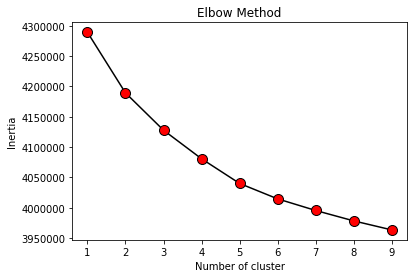

CPU times: user 8.66 s, sys: 1.89 s, total: 10.6 s
Wall time: 1h 22min 23s


In [175]:
%%time

sse = {}
data = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters= k, n_jobs = -1).fit(X_train_bow)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    data.append([k, sse[k]])
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color= 'black',marker = 'o',
             markerfacecolor = 'red', markersize = 10)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title('Elbow Method')
plt.show()

In [176]:
%%time

kmeans = KMeans(n_clusters= 10, max_iter = 300, n_jobs = -1).fit(X_train_bow) #default initialization = 10


CPU times: user 1.18 s, sys: 256 ms, total: 1.44 s
Wall time: 15min 36s


In [177]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [198]:
kmeans.labels_

array([6, 6, 6, ..., 4, 6, 6], dtype=int32)

In [179]:
kmeans.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.00035702, 0.        ,
        0.        ],
       [0.00042494, 0.00010624, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [180]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
centroids

array([[ 7837, 10198, 27820, ..., 19128, 19129,     0],
       [15427, 26750, 10006, ..., 15538, 15539, 30871],
       [15427, 28857, 26750, ..., 18373, 18374,     0],
       ...,
       [10198,  4270,  7837, ..., 19622, 19623,     0],
       [ 4907,  2006, 26750, ..., 19555, 19556,     0],
       [ 5380, 10006, 26750, ..., 19392, 19394,     0]])

In [186]:
kmeans.inertia_

3945478.2248024493

In [57]:
terms = count_vect.get_feature_names()



 Cluster 0:



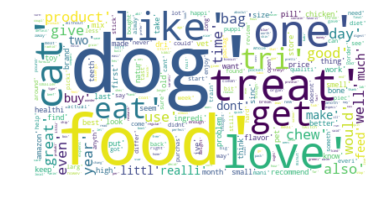


 Cluster 1:



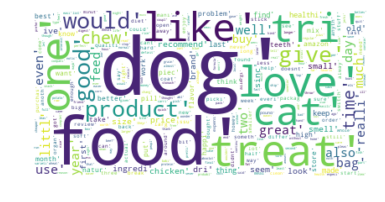


 Cluster 2:



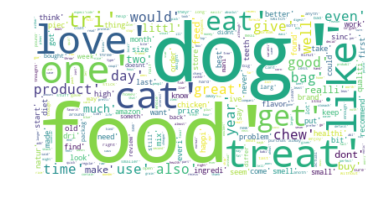


 Cluster 3:



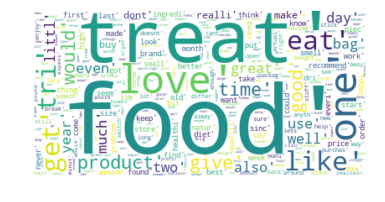


 Cluster 4:



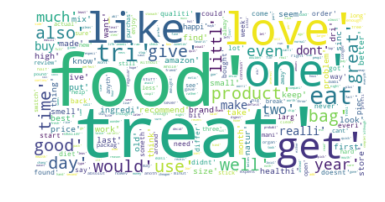


 Cluster 5:



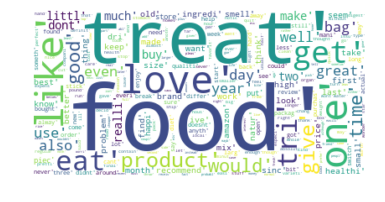


 Cluster 6:



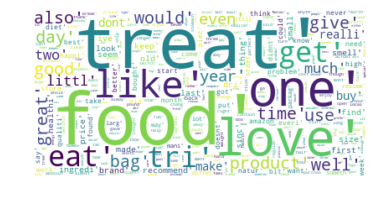


 Cluster 7:



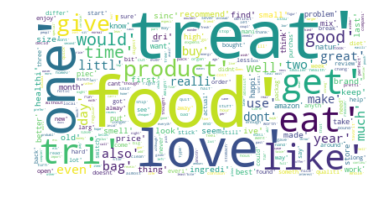


 Cluster 8:



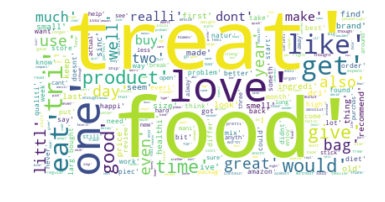

In [208]:
store = []
stop =  set(STOPWORDS)
for i in range(9):
    print("\n Cluster %d:\n" % i)
    for j in centroids[i, :1000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    

# Tf-idf:

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), max_features = 25000)
X_train_tf = tf_idf_vect.fit_transform(X_train)

X_test_tf = tf_idf_vect.transform(X_test)

In [37]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[20:40])

some sample features(unique words in the corpus) ['absolut amaz', 'absolut best', 'absolut delici', 'absolut delight', 'absolut disgust', 'absolut fantast', 'absolut favorit', 'absolut great', 'absolut hate', 'absolut horribl', 'absolut love', 'absolut noth', 'absolut perfect', 'absolut wonder', 'absorb', 'absorb flavor', 'absurd', 'abund', 'abus', 'acai']



#  Kmeans++:

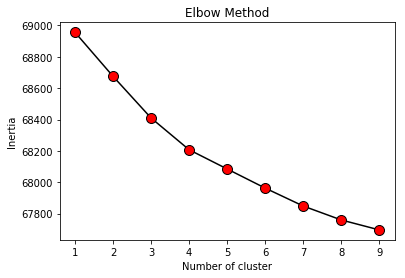

In [226]:
#SOURCE: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

sse = {}
data = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters= k, n_jobs = -1).fit(X_train_tf)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    data.append([k, sse[k]])
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color= 'black',marker = 'o',
             markerfacecolor = 'red', markersize = 10)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title('Elbow Method')
plt.show()

In [241]:
%%time

kmeans = KMeans(n_clusters= 10, max_iter = 300, n_jobs = -1).fit(X_train_tf) #default initialization = 10


CPU times: user 1.67 s, sys: 362 ms, total: 2.03 s
Wall time: 24min 11s


In [242]:
kmeans.labels_

array([8, 3, 1, ..., 9, 7, 3], dtype=int32)

In [243]:
kmeans.cluster_centers_

array([[0.00000000e+00, 5.46255364e-05, 2.14294049e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.30555073e-05, 1.38896960e-04, 2.35136617e-03, ...,
        1.97518944e-05, 2.71025469e-04, 6.25926881e-05],
       [1.44536313e-04, 1.12885326e-04, 2.46526305e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 4.36985834e-04, 2.75548124e-03, ...,
        0.00000000e+00, 2.47851316e-03, 5.10344659e-04],
       [3.41529470e-05, 1.96172473e-04, 6.88112661e-03, ...,
        1.06538651e-05, 2.29154575e-05, 0.00000000e+00],
       [0.00000000e+00, 1.52428036e-04, 2.39046203e-03, ...,
        5.31309592e-04, 0.00000000e+00, 0.00000000e+00]])

In [244]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
centroids

array([[ 3287,  8255,  3305, ..., 14273, 14272,     0],
       [12862,  9794, 15115, ..., 18662, 18663,  1494],
       [ 3686,  1466,  4577, ..., 10106, 21069, 24999],
       ...,
       [ 5854, 22608,  8255, ..., 13430, 13429,     0],
       [16920,   629, 15442, ...,  4871, 16687, 24999],
       [23180, 18622, 15024, ...,  9752,  9768,     0]])

In [245]:
kmeans.inertia_

67606.18302632403


 Cluster 0:



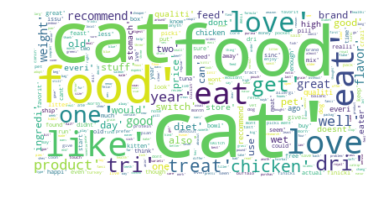


 Cluster 1:



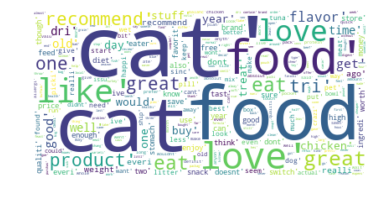


 Cluster 2:



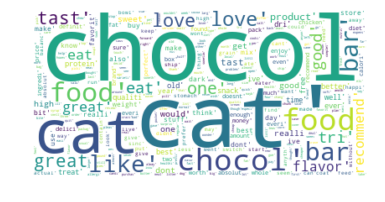


 Cluster 3:



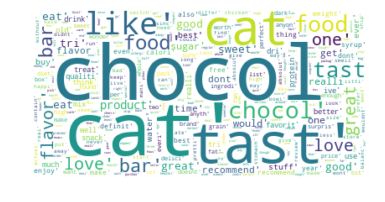


 Cluster 4:



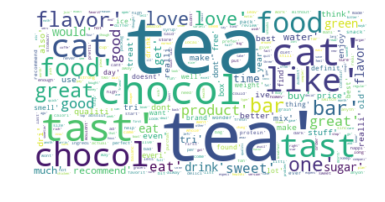


 Cluster 5:



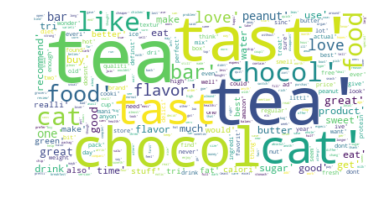


 Cluster 6:



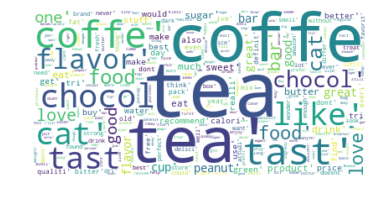


 Cluster 7:



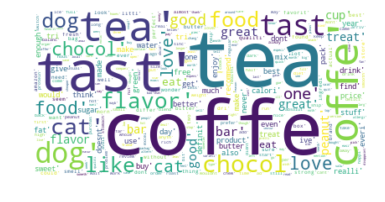


 Cluster 8:



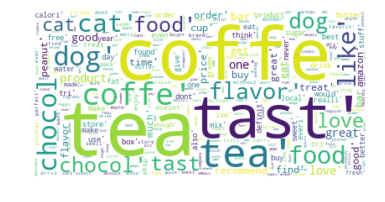

In [246]:
store = []
stop =  set(STOPWORDS)
for i in range(9):
    print("\n Cluster %d:\n" % i)
    for j in centroids[i, :1000]:
        store.append(features[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()


# Word 2 vec:

In [19]:
from tqdm import tqdm
from sklearn import preprocessing

In [20]:
i=0
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

In [21]:
w2v_model = Word2Vec(list_of_sent,min_count=5,size= 100, workers=4)

In [22]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

new mozzarella flavor incred addict went entir box one sit tast much better origin bland product high recommend prone addict
*****************************************************************
['favorit', 'flavor', 'greeni', 'far', 'realli', 'tast', 'tuna', 'doesnt', 'overpow', 'distinct', 'felin', 'flavor', 'admit', 'skeptic', 'soylent', 'greeni', 'wonder', 'could', 'realli', 'captur', 'great', 'kitti', 'tast', 'small', 'bite', 'size', 'morsel', 'could', 'eat', 'day', 'long', 'best', 'thing', 'also', 'good', 'teeth', 'dentist', 'impress']


In [23]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  10922
sample words  ['favorit', 'flavor', 'greeni', 'far', 'realli', 'tast', 'tuna', 'doesnt', 'overpow', 'distinct', 'felin', 'admit', 'skeptic', 'wonder', 'could', 'captur', 'great', 'kitti', 'small', 'bite', 'size', 'morsel', 'eat', 'day', 'long', 'best', 'thing', 'also', 'good', 'teeth', 'dentist', 'impress', 'first', 'keurig', 'purchas', 'januari', 'maci', 'die', 'work', 'morn', 'later', 'power', 'light', 'noth', 'tri', 'reviv', 'disappoint', 'unit', 'month', 'hour']


In [24]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 70000/70000 [01:03<00:00, 1095.01it/s]

70000
100


In [38]:
X_train_wv = sent_vectors
X_train_wv = preprocessing.normalize(X_train_wv)

In [1]:
sse = {}
data = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters= k, n_jobs = -1).fit(X_train_wv)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    data.append([k, sse[k]])
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color= 'black',marker = 'o',
             markerfacecolor = 'red', markersize = 10)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title('Elbow Method')
plt.show()

NameError: name 'KMeans' is not defined

In [63]:
%%time

kmeans = KMeans(n_clusters= 20, max_iter = 300, n_jobs = -1).fit(X_train_wv) #default initialization = 10


CPU times: user 1.29 s, sys: 159 ms, total: 1.45 s
Wall time: 25.7 s


In [64]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
centroids

array([[50,  1, 33, ..., 71, 74, 70],
       [28, 68, 57, ..., 13, 48, 98],
       [72, 52,  4, ..., 70, 71, 48],
       ...,
       [50,  1, 22, ..., 70, 93, 71],
       [28, 60, 92, ..., 71, 65, 98],
       [50, 47, 68, ..., 55, 71, 23]])

In [65]:
kmeans.labels_

array([ 7,  1, 19, ..., 16, 12, 11], dtype=int32)

In [66]:
kmeans.inertia_

29792.583941790246


 Cluster 0:



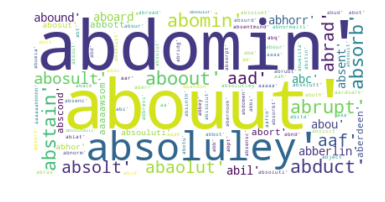


 Cluster 1:



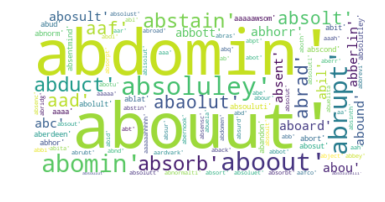


 Cluster 2:



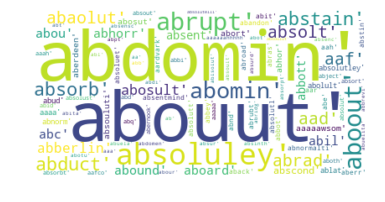


 Cluster 3:



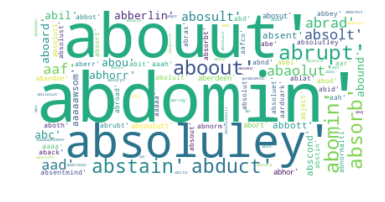


 Cluster 4:



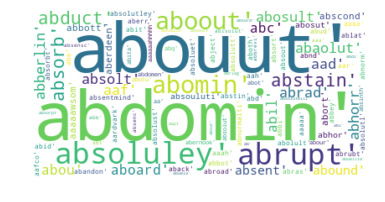


 Cluster 5:



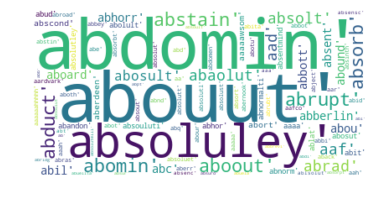


 Cluster 6:



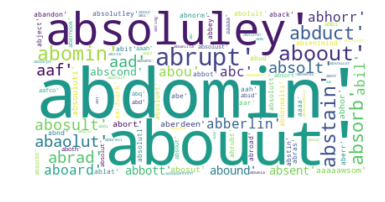


 Cluster 7:



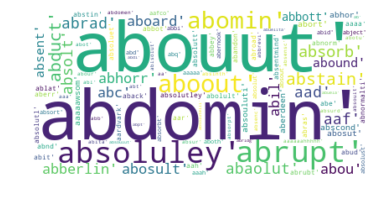


 Cluster 8:



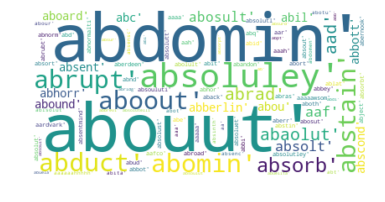


 Cluster 9:



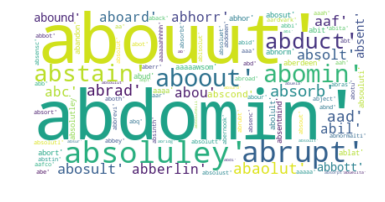


 Cluster 10:



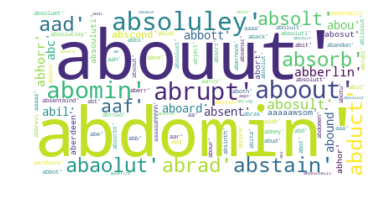


 Cluster 11:



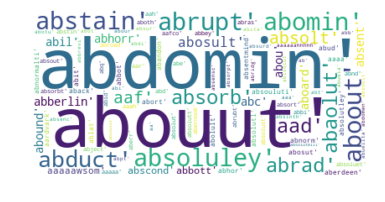


 Cluster 12:



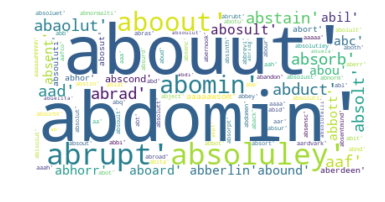


 Cluster 13:



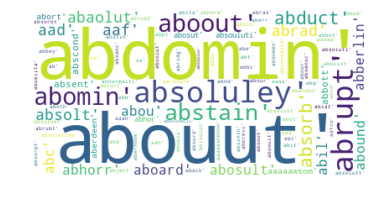


 Cluster 14:



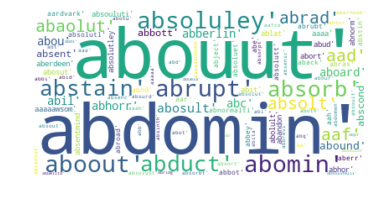


 Cluster 15:



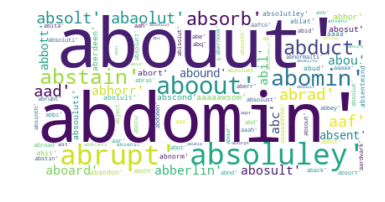

In [86]:
#SOURCE: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

store = []
stop =  set(STOPWORDS)
for i in range(16):
    print("\n Cluster %d:\n" % i)
    for j in centroids[i, :1000]:
        store.append(terms[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [26]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [27]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [01:17<00:00, 905.73it/s] 


In [28]:
X_train_twv = tfidf_sent_vectors
X_train_twv = preprocessing.normalize(X_train_twv)

In [30]:
X_train_twv

array([[-0.09117305,  0.07960555, -0.09578374, ..., -0.0403406 ,
        -0.08521654, -0.08106906],
       [-0.04959962, -0.04862178,  0.14474437, ...,  0.09088092,
        -0.20467721,  0.11153729],
       [-0.12396683,  0.04710259,  0.10758981, ..., -0.06615296,
        -0.05637547,  0.1997288 ],
       ...,
       [-0.12002614,  0.14603604,  0.07842188, ..., -0.01306605,
        -0.03862153,  0.06915249],
       [-0.05112319,  0.09784311,  0.01274978, ...,  0.17938047,
        -0.24962221, -0.1313065 ],
       [-0.01714678,  0.19157406,  0.12819767, ..., -0.07869613,
         0.02060413, -0.15811027]])

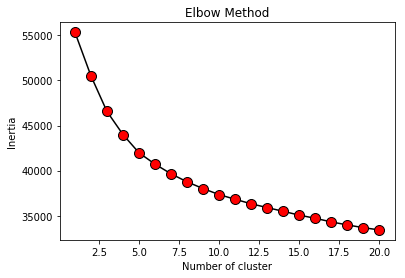

In [69]:
sse = {}
data = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters= k, n_jobs = -1).fit(X_train_twv)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    data.append([k, sse[k]])
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), color= 'black',marker = 'o',
             markerfacecolor = 'red', markersize = 10)
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.title('Elbow Method')
plt.show()

In [87]:
%%time

kmeans = KMeans(n_clusters= 17, max_iter = 300, n_jobs = -1).fit(X_train_twv) #default initialization = 10
kmeans

CPU times: user 1.39 s, sys: 190 ms, total: 1.58 s
Wall time: 21.2 s


In [88]:
centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
centroids

array([[28,  1, 77, ..., 70, 93, 71],
       [92, 50, 49, ..., 71, 98, 48],
       [50,  1, 33, ..., 93, 23, 71],
       ...,
       [77, 91, 92, ..., 70, 11,  3],
       [28, 77, 63, ..., 80, 61, 41],
       [50, 33, 37, ..., 74, 99, 70]])

In [89]:
kmeans.labels_

array([12,  5,  3, ..., 15,  5, 16], dtype=int32)

In [90]:
kmeans.inertia_

34315.4489798262


 Cluster 0:



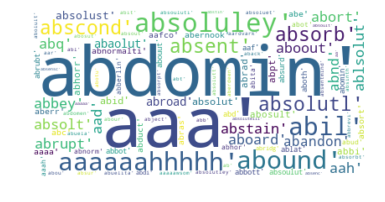


 Cluster 1:



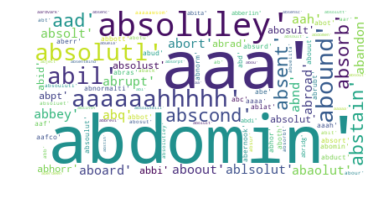


 Cluster 2:



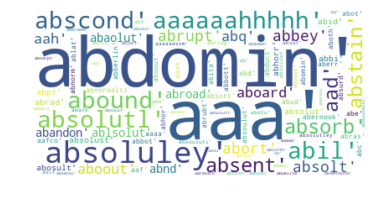


 Cluster 3:



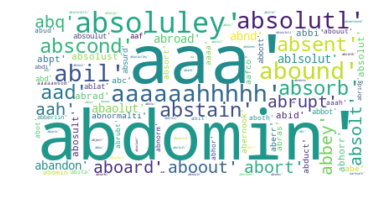


 Cluster 4:



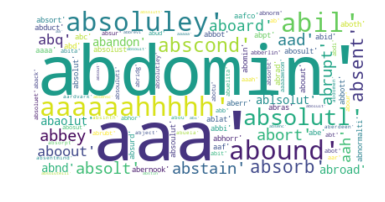


 Cluster 5:



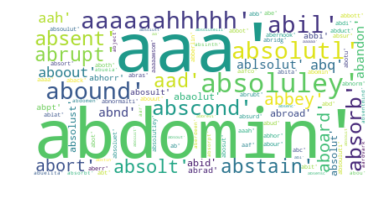


 Cluster 6:



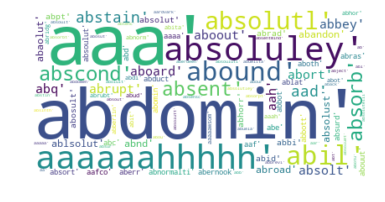


 Cluster 7:



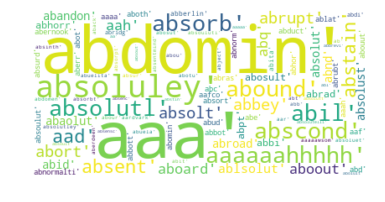


 Cluster 8:



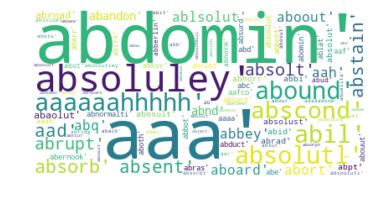


 Cluster 9:



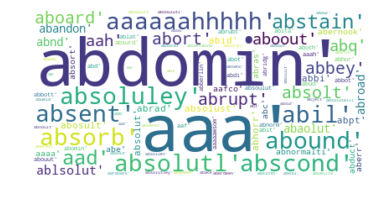


 Cluster 10:



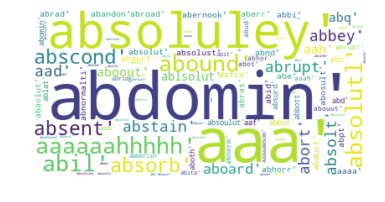


 Cluster 11:



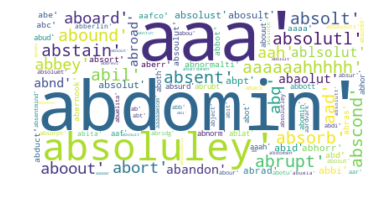


 Cluster 12:



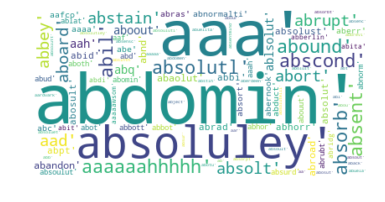


 Cluster 13:



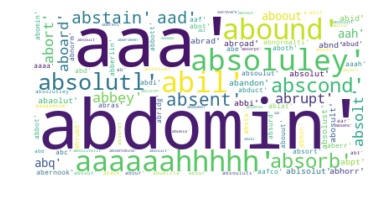


 Cluster 14:



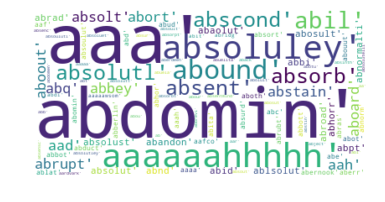


 Cluster 15:



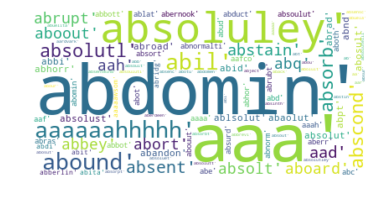


 Cluster 16:



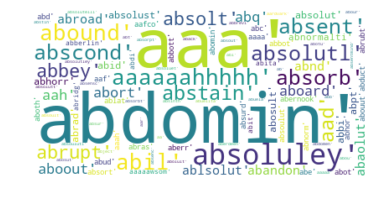

In [91]:
#SOURCE: https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion

store = []
stop =  set(STOPWORDS)
for i in range(17):
    print("\n Cluster %d:\n" % i)
    for j in centroids[i, :1000]:
        store.append(tfidf_feat[j])
        #print(' %s' % terms[j]),
    #print
   
    wc = WordCloud(background_color="white", max_words=len(str(store)), stopwords=stop)
    wc.generate(str(store))
   # print("Word Cloud forCluster:", i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()